<a href="https://www.kaggle.com/code/dipds109/gringotts-bank-s4e1-catboost-0-896?scriptVersionId=160390415" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="display: flex; flex-direction: row; align-items: center;">
    <div style="flex: 0; margin-top: 8px;">
        <img src="https://i.pinimg.com/564x/9e/2a/9d/9e2a9dc56446535c84ddd7dbc1466914.jpg" alt="Image" style="max-width: 500px; max-height: 600px;" />
    </div>
    <div style="flex: 1; margin-left: 30px; margin-top: 6px">
        <p style="font-weight: bold; color: White; font-size: 17px">Introduction</p>
        <p></p>
        <p><b>Data Preparation and Exploration:</b> We start by importing necessary libraries and exploring the dataset, which includes customer attributes like credit score, geography, gender, and account details.</p>
        <p><b>Feature Engineering:</b> We enhance the data by creating new features and modifying existing ones to better capture patterns related to customer churn.</p>
        <p><b>Preprocessing and Model Training:</b> A preprocessing pipeline is implemented for data transformation, followed by training a CatBoost classifier model. The model is evaluated using Stratified K-Fold cross-validation with the AUC metric.</p>
        <p><b>Feature Importance and SHAP Analysis:</b> Post-training, we analyze feature importance using both CatBoost's built-in functionality and permutation importance. Additionally, SHAP values are utilized for a deeper understanding of feature impacts on predictions.</p>
        <p><b>Prediction and Submission:</b> Finally, predictions are made on the test set, considering a potential data leakage strategy for accuracy improvement. The final predictions are then formatted for submission.</p>
        <blockquote>  Please upvote if you like my work </blockquote>
    </div>
</div>




In [1]:
#Basic libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn library
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import  cross_val_score #Hyperparameter Tuning


#catboost library
from catboost import CatBoostClassifier, Pool



# 1. Data Exploration: <a name="data"></a>


## Data Description:

- **Customer ID:** A unique identifier for each customer
- **Surname:** The customer's surname or last name
- **Credit Score:** A numerical value representing the customer's credit score
- **Geography:** The country where the customer resides
- **Gender:** The customer's gender
- **Age:** The customer's age.
- **Tenure:** The number of years the customer has been with the bank
- **Balance:** The customer's account balance
- **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
- **HasCrCard:** Whether the customer has a credit card
- **IsActiveMember:** Whether the customer is an active member
- **EstimatedSalary:** The estimated salary of the customer
- **Exited:** Whether the customer has churned (Target Variable)

### Reading the data

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

### 1.1 Train Data

In [3]:
train_data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
# Counting the number of instances where 'Exited' is equal to 1
num_rows_exited_1 = train_data[train_data['Exited'] == 1].shape[0]
num_rows_exited_1

34921

In [6]:
# Counting the number of instances where 'Exited' is equal to 0
num_rows_exited_0 = train_data[train_data['Exited'] == 0].shape[0]
num_rows_exited_0

130113

### 1.2 Test Data

In [7]:
test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


# 2. Feature Engineering

Reference:
https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble#4.3-Numerical-Clustering

In [9]:
class AgeBin(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['Age'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Age',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
    

In [10]:
class CreditScoreBins(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['CreditScore'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_CreditScore',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
CreditScoreBins(5).fit_transform(train_data)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut5_CreditScore
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,2
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,2
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,4
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0


In [11]:
class SalaryBins(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['EstimatedSalary'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Est_Salary',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
SalaryBins(10).fit_transform(train_data)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut10_Est_Salary
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,9
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,9
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,5
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,5
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,5
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2


In [12]:
class BalanceSalaryRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Balance_Salary_Ratio'] = X_copy['Balance'] / X_copy['EstimatedSalary']
        
        return X_copy

BalanceSalaryRatio().fit_transform(train_data) 

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_Salary_Ratio
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.000000
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.000000
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.000000
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.760655
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.000000
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.000000
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0.000000
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2.269582


In [13]:
class GeoGender(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Geo_Gender'] = X_copy['Geography'] + '_' + X_copy['Gender']
        return X_copy
    
GeoGender().fit_transform(train_data)  

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_Gender
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,France_Male
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,France_Male
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,France_Male
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,France_Male
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,Spain_Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,Spain_Female
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,France_Male
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,France_Male
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,Spain_Female


In [14]:
class TotalProducts(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Total_Products_Used'] = X_copy['NumOfProducts'] + X_copy['HasCrCard']
        return X_copy

TotalProducts().fit_transform(train_data)   

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Total_Products_Used
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,3.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,3.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,2.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2.0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,2.0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,1.0


In [15]:
class TpGenderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_products_field='Total_Products_Used', gender_field='Gender'):
        self.total_products_field = total_products_field
        self.gender_field = gender_field
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Tp_Gender'] = X_copy[self.total_products_field].astype('str') + X_copy[self.gender_field]
        return X_copy

train_tp = TotalProducts().fit_transform(train_data)   
TpGenderTransformer().fit_transform(train_tp)    

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Total_Products_Used,Tp_Gender
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,3.0,3.0Male
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,3.0,3.0Male
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3.0,3.0Male
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,2.0,2.0Male
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,3.0,3.0Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2.0,2.0Female
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1.0,1.0Male
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,2.0,2.0Male
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,1.0,1.0Female


In [16]:
class IsSenior(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        X_copy=X.copy()
        X_copy['IsSenior'] = X_copy['Age'].apply(lambda x: 1 if x >= 60 else 0)
        return X_copy
        
IsSenior().fit_transform(train_data)   

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsSenior
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0


In [17]:
class ActiveCC(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        X_copy= X.copy()
        X_copy['ActiveCC']=X_copy['HasCrCard'] * X_copy['IsActiveMember']
        return X_copy
    
ActiveCC().fit_transform(train_data)   

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,ActiveCC
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1.0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1.0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.0


In [18]:

class ProductsPerTenure(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['Products_Per_Tenure'] = X_copy['Tenure'] / X_copy['NumOfProducts'].replace(0, float('inf'))
        return X_copy


In [19]:
class TFIDFPCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, max_features, n_components):
        self.column = column
        self.max_features = max_features
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.svd = TruncatedSVD(n_components=n_components)

    def fit(self, X, y=None):
        vectors = self.vectorizer.fit_transform(X[self.column])
        self.svd.fit(vectors)
        return self

    def transform(self, X):
        vectors = self.vectorizer.transform(X[self.column])
        svd_result = self.svd.transform(vectors)

        tfidf_df = pd.DataFrame(svd_result, columns=[f"{self.column}_tfidf_{i}" for i in range(self.n_components)])
        X = pd.concat([X, tfidf_df], axis="columns")
        return X
    
TFIDFPCATransformer(column="Surname", max_features=1000, n_components=5).fit_transform(train_data) 

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1.047191e-07,-4.303737e-07,-9.435032e-07,1.161552e-06,-1.679442e-06
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,2.685471e-08,2.689787e-07,1.698265e-06,1.155831e-06,-1.129774e-05
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,4.050723e-04,-1.392099e-03,1.015717e-03,1.648649e-04,1.986784e-03
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,9.307493e-05,-2.885753e-03,-8.641837e-04,1.063365e-02,-8.638808e-03
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,2.255261e-08,3.271522e-07,7.211736e-07,5.616119e-07,1.634757e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1.489248e-11,-1.946133e-10,9.973994e-11,9.770104e-10,-9.248254e-10
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,-4.292511e-08,-5.257463e-07,-1.385785e-06,-2.729873e-06,-2.467799e-06
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,2.019753e-05,9.999475e-01,2.400437e-03,-3.053596e-04,-1.749999e-04
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,-4.611454e-04,1.072011e-03,1.432666e-03,5.806811e-03,-2.468271e-03


In [20]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

In [21]:
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# 3. Creating the pipeline

In [22]:
named_preprocessing_pipeline = Pipeline([
    ('surname_tfid', TFIDFPCATransformer(column="Surname", max_features=1000, n_components=5)),
    ('age_binning', AgeBin(5)),
    ('salary_binning', SalaryBins(10)),
    ('balance_salary_ratio', BalanceSalaryRatio()),
    ('geo_gender', GeoGender()),
    ('total_products', TotalProducts()),
    ('Is_Senior', IsSenior()),
    ('product_per_tenure',ProductsPerTenure()),
    ('active_cc',ActiveCC()),
    ('tp_gender', TpGenderTransformer()),
  
])

named_preprocessing_pipeline                            

Pipeline(steps=[('surname_tfid',
                 TFIDFPCATransformer(column='Surname', max_features=1000,
                                     n_components=5)),
                ('age_binning', AgeBin(n_bins=5)),
                ('salary_binning', SalaryBins(n_bins=10)),
                ('balance_salary_ratio', BalanceSalaryRatio()),
                ('geo_gender', GeoGender()),
                ('total_products', TotalProducts()), ('Is_Senior', IsSenior()),
                ('product_per_tenure', ProductsPerTenure()),
                ('active_cc', ActiveCC()),
                ('tp_gender', TpGenderTransformer())])

In [23]:
df_train = named_preprocessing_pipeline.fit_transform(train_data.drop(['Exited'], axis=1))
y = train_data['Exited']
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    165034 non-null  int64  
 1   CustomerId            165034 non-null  int64  
 2   Surname               165034 non-null  object 
 3   CreditScore           165034 non-null  int64  
 4   Geography             165034 non-null  object 
 5   Gender                165034 non-null  object 
 6   Age                   165034 non-null  float64
 7   Tenure                165034 non-null  int64  
 8   Balance               165034 non-null  float64
 9   NumOfProducts         165034 non-null  int64  
 10  HasCrCard             165034 non-null  float64
 11  IsActiveMember        165034 non-null  float64
 12  EstimatedSalary       165034 non-null  float64
 13  Surname_tfidf_0       165034 non-null  float64
 14  Surname_tfidf_1       165034 non-null  float64
 15  

In [24]:
df_test = pd.DataFrame(named_preprocessing_pipeline.transform(test_data))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    110023 non-null  int64  
 1   CustomerId            110023 non-null  int64  
 2   Surname               110023 non-null  object 
 3   CreditScore           110023 non-null  int64  
 4   Geography             110023 non-null  object 
 5   Gender                110023 non-null  object 
 6   Age                   110023 non-null  float64
 7   Tenure                110023 non-null  int64  
 8   Balance               110023 non-null  float64
 9   NumOfProducts         110023 non-null  int64  
 10  HasCrCard             110023 non-null  float64
 11  IsActiveMember        110023 non-null  float64
 12  EstimatedSalary       110023 non-null  float64
 13  Surname_tfidf_0       110023 non-null  float64
 14  Surname_tfidf_1       110023 non-null  float64
 15  

In [25]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Surname_tfidf_4,QCut5_Age,QCut10_Est_Salary,Balance_Salary_Ratio,Geo_Gender,Total_Products_Used,IsSenior,Products_Per_Tenure,ActiveCC,Tp_Gender
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,7.356746e-08,1,9,0.000000,France_Male,3.0,0,1.5,0.0,3.0Male
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,2.969622e-06,1,1,0.000000,France_Male,3.0,0,0.5,1.0,3.0Male
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,2.394911e-03,3,9,0.000000,France_Male,3.0,0,5.0,0.0,3.0Male
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,-4.821840e-03,1,3,1.760655,France_Male,2.0,0,2.0,1.0,2.0Male
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,3.194510e-06,1,0,0.000000,Spain_Male,3.0,0,2.5,1.0,3.0Male


## 4. Scaling

In [26]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary','Total_Products_Used','Products_Per_Tenure']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

In [27]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsSenior,Products_Per_Tenure,ActiveCC,Tp_Gender,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Total_Products_Used_scaled,Products_Per_Tenure_scaled
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0,1.5,0.0,3.0Male,0.202703,0.636,0.000000,0.907279,0.50,0.15
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0,0.5,1.0,3.0Male,0.202703,0.554,0.000000,0.247483,0.50,0.05
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0,5.0,0.0,3.0Male,0.297297,0.656,0.000000,0.924364,0.50,0.50
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,2.0,1.0,2.0Male,0.216216,0.462,0.593398,0.422787,0.25,0.20
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0,2.5,1.0,3.0Male,0.202703,0.732,0.000000,0.075293,0.50,0.25


In [28]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsSenior,Products_Per_Tenure,ActiveCC,Tp_Gender,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Total_Products_Used_scaled,Products_Per_Tenure_scaled
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,...,0,1.0,0.0,2.0Female,0.067568,0.472,0.000000,0.804903,0.25,0.10
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,...,0,2.0,0.0,2.0Female,0.378378,0.666,0.000000,0.362723,0.25,0.20
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,...,0,3.5,0.0,3.0Female,0.216216,0.612,0.000000,0.694419,0.50,0.35
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,...,0,8.0,0.0,2.0Male,0.243243,0.662,0.000000,0.569654,0.25,0.80
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,...,0,10.0,0.0,2.0Male,0.270270,0.804,0.483318,0.697164,0.25,1.00


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_train, 
                                                    y, 
                                                    random_state=42, 
                                                    stratify=y)

In [30]:
feat_cols=df_train.columns.drop(['id'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Surname_tfidf_0',
       'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3',
       'Surname_tfidf_4', 'QCut5_Age', 'QCut10_Est_Salary',
       'Balance_Salary_Ratio', 'Geo_Gender', 'IsSenior', 'ActiveCC',
       'Tp_Gender', 'Age_scaled', 'CreditScore_scaled', 'Balance_scaled',
       'EstimatedSalary_scaled', 'Total_Products_Used_scaled',
       'Products_Per_Tenure_scaled'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsSenior,Products_Per_Tenure,ActiveCC,Tp_Gender,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Total_Products_Used_scaled,Products_Per_Tenure_scaled
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0,1.5,0.0,3.0Male,0.202703,0.636,0.000000,0.907279,0.50,0.15
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0,0.5,1.0,3.0Male,0.202703,0.554,0.000000,0.247483,0.50,0.05
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0,5.0,0.0,3.0Male,0.297297,0.656,0.000000,0.924364,0.50,0.50
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,2.0,1.0,2.0Male,0.216216,0.462,0.593398,0.422787,0.25,0.20
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0,2.5,1.0,3.0Male,0.202703,0.732,0.000000,0.075293,0.50,0.25


In [31]:
X=df_train[feat_cols]

##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5, 13, 14, 16, 17, 19])

# 5. Preparing Models and Testing

In [32]:
num_folds = 5
RAND_VAL = 42

In [33]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.022,
    iterations=3500)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

0:	test: 0.8661841	best: 0.8661841 (0)	total: 339ms	remaining: 19m 46s
300:	test: 0.8942086	best: 0.8942086 (300)	total: 1m 11s	remaining: 12m 39s
600:	test: 0.8961857	best: 0.8961857 (600)	total: 2m 23s	remaining: 11m 33s
900:	test: 0.8968580	best: 0.8968591 (899)	total: 3m 36s	remaining: 10m 24s
1200:	test: 0.8971803	best: 0.8971803 (1200)	total: 4m 49s	remaining: 9m 14s
1500:	test: 0.8973265	best: 0.8973297 (1487)	total: 6m 3s	remaining: 8m 4s
1800:	test: 0.8974324	best: 0.8974494 (1741)	total: 7m 18s	remaining: 6m 53s
2100:	test: 0.8974433	best: 0.8974703 (1919)	total: 8m 32s	remaining: 5m 41s
2400:	test: 0.8974438	best: 0.8974703 (1919)	total: 9m 45s	remaining: 4m 27s
2700:	test: 0.8974884	best: 0.8975071 (2611)	total: 10m 59s	remaining: 3m 15s
3000:	test: 0.8974902	best: 0.8975221 (2857)	total: 12m 14s	remaining: 2m 2s
3300:	test: 0.8974835	best: 0.8975221 (2857)	total: 13m 30s	remaining: 48.8s
3499:	test: 0.8974509	best: 0.8975221 (2857)	total: 14m 20s	remaining: 0us

bestTest =

In [34]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.8978978579802324)

# Validation and Visualization

Feature importance assigns a score to each feature, reflecting its significance in the construction of the model's boosted decision trees. The frequency and impact of a feature in making critical decisions within these trees determine its relative importance. In essence, the more integral a feature is to decision-making processes in the model, the greater its attributed importance.

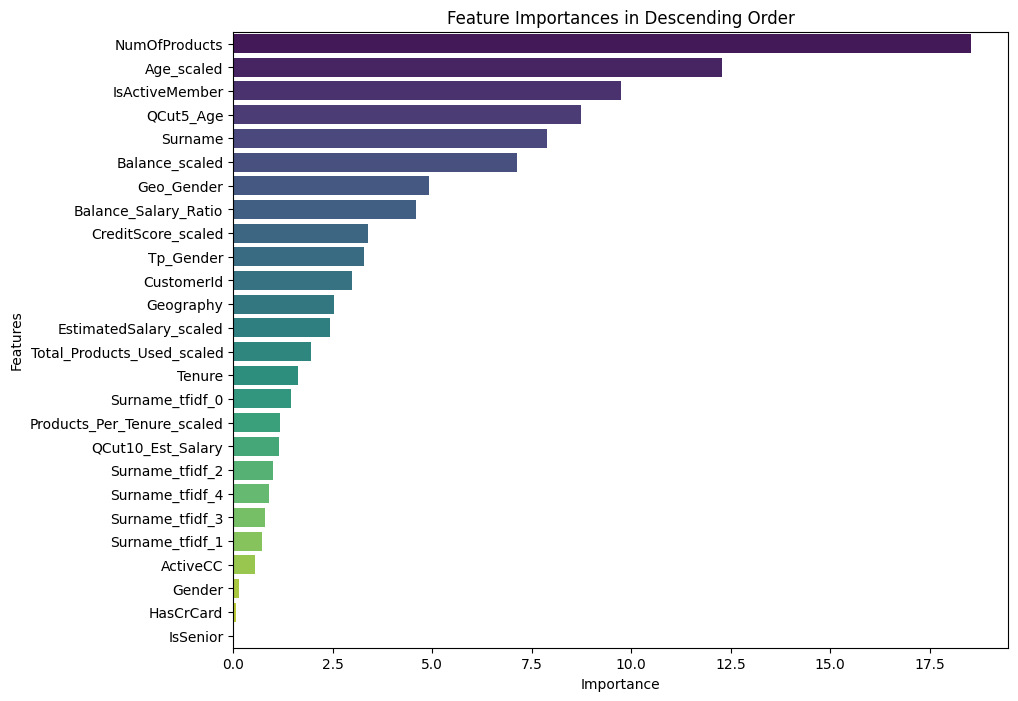

In [35]:
feature_importances = clf.get_feature_importance()
feature_names = X.columns

# Create a Series for easier plotting
importances = pd.Series(feature_importances, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=importances_sorted.index, x=importances_sorted.values, palette="viridis")
plt.title('Feature Importances in Descending Order')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


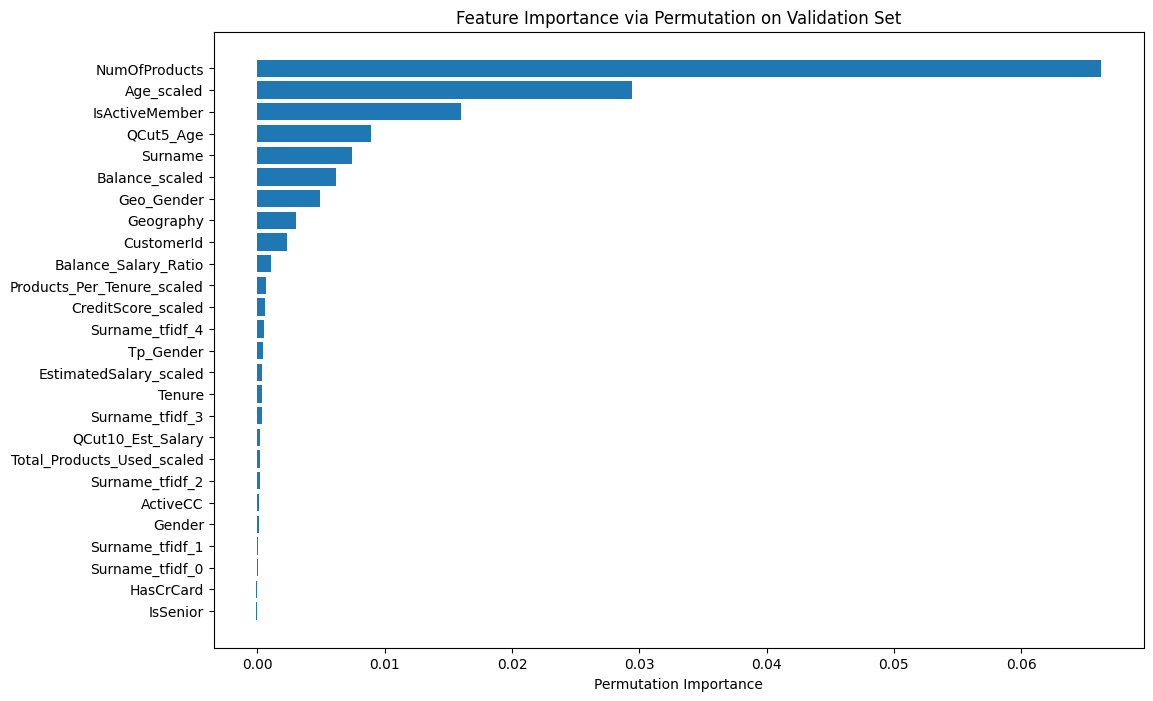

In [36]:

from sklearn.inspection import permutation_importance

# Select the validation set from your last fold (or you could average over folds)
X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

# Calculate Permutation Importance
perm_importance = permutation_importance(clf, X_val, y_val, n_repeats=10, random_state=RAND_VAL)

# Sorting the importances
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_val.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation on Validation Set")
plt.show()



SHAP (SHapley Additive exPlanations) is a method used in machine learning to explain the output of any model. It is grounded in game theory and provides a way to interpret the contribution of each feature to the prediction made by the model. SHAP values essentially break down a prediction to show the impact of each feature.

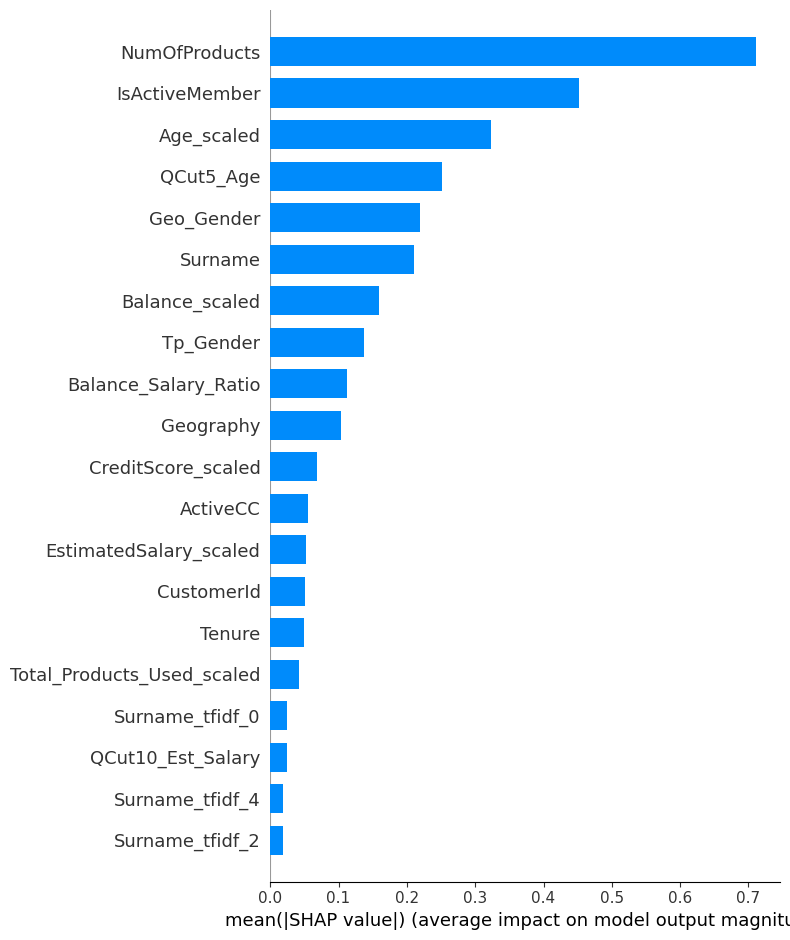

In [37]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [38]:
USE_DATA_LEAK='Y'

In [39]:
df_test_ov= df_test.copy()

### Prediction override

In [40]:
y_pred = test_preds.mean(axis=0)
df_orig=pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
join_cols=list(df_orig.columns.drop(['RowNumber','Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
####
df_sub = df_test_ov[['id','Exited_Orig']]

if USE_DATA_LEAK=='Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred
    
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()


,id,Exited
0,165034,0.014829
1,165035,0.821584
2,165036,0.016667
3,165037,0.209243
4,165038,0.415329


In [41]:
df_sub.to_csv("submission_final.csv",index=False)